In [1]:
from preproc_utils import *
from Get_PSSM import *
from Get_dataset import *
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
chebi = pd.read_table('/Users/suhancho/data/Uniprot_metalbinding_challenge/POS_TRAIN_FULL.tsv')
inpath = '/Users/suhancho/data/Uniprot_metalbinding_challenge/chebi/'
bind_tsv_list = [inpath + f for f in os.listdir(inpath)]
pssm_path = '/Users/suhancho/data/Uniprot_metalbinding_challenge/PSSM/'
pssm_files = [pssm_path+f for f in os.listdir(pssm_path)]

In [2]:
def calculate_window(num_inspections,bs_idx):
    train_dat=[]
    for i,pssm in tqdm(enumerate(pssm_files[0:num_inspections])):
        ion_file =bind_tsv_list[bs_idx] # bs_idx : 0~29
        ion_name = ion_file.split('/')[-1].split('.')[0]
        bs = get_binding_site(ion_file,pssm.split('/')[-1].split('.')[0])
        try : 
            if len(bs)!=0:
                # gt,fs = get_dataset(get_processed_pssm(pssm),bs)
                gt,fs = get_dataset_padded(get_processed_pssm(pssm),bs)
                # print("Number of positive windows:"+str(len(gt))+'\n'+
                #       "Number of negative windows:"+str(len(fs)))
                for g in gt : 
                    train_dat.append([g.values.tolist(),1])
                for f in fs : 
                    train_dat.append([f.values.tolist(),0])
        except:
            print(pssm)

    return(train_dat,ion_name)

In [3]:
def preproc_data(windowdata):
    train_X = [dat[0] for dat in windowdata]
    train_Y = [dat[1] for dat in windowdata]
    print('Size of dataset : '+str(len(train_X)))
    return(train_X,train_Y)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
def check_windowdata(traindata):
    sns.histplot([len(t) for t in traindata])
    plt.show()



In [5]:
def filter_traindata(Xdata,Ydata):
    train_X_filtered = [Xdata[i] for i in range(len(Xdata)) if len(Xdata[i])==9]
    train_Y_filtered = [Ydata[i] for i in range(len(Xdata)) if len(Xdata[i])==9]
    return(train_X_filtered,train_Y_filtered)  

In [6]:
from itertools import chain
def flatten_Xdata(filtered_X):
    flatten_trainX = [list(chain.from_iterable(lst)) for lst in filtered_X]
    return(flatten_trainX)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score
def get_MLmetrics(testset_y,testset_X,classifier,ion_name):
    auc = roc_auc_score(testset_y,list(classifier.predict(testset_X)))
    acc = accuracy_score(testset_y,list(classifier.predict(testset_X)))
    recall = recall_score(testset_y,list(classifier.predict(testset_X)))
    f1 = f1_score(testset_y,list(classifier.predict(testset_X)))
    prec = precision_score(testset_y,list(classifier.predict(testset_X)))
    print('ION = '+ion_name)
    print('\nAUC = '+str(round(auc,2)))
    print('\nAccuracy = '+str(round(acc,2)))
    print('\nRecall = '+str(round(recall,2)))
    print('\nF1 = '+str(round(f1,2)))
    print('Precision = '+str(round(prec,2)))
    return(0)

In [9]:
def balance_classes(traindata,fold):
    label1 = [traindata[i] for i in range(len(traindata)) if traindata[i][1]==1]
    label0 = [traindata[i] for i in range(len(traindata)) if traindata[i][1]==0]
    balanced0 = random.sample(label0,len(label1)*fold)
    return(balanced0+label1)

900it [00:18, 49.19it/s]


Size of dataset : 177


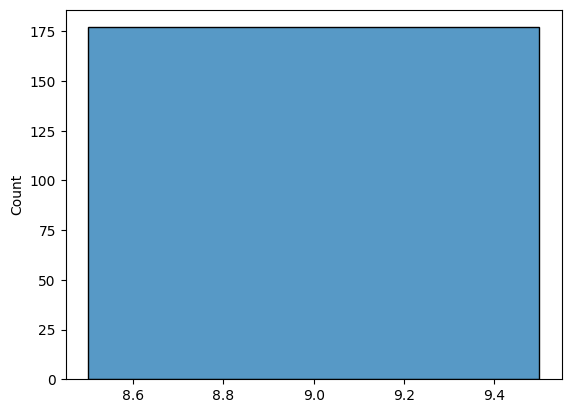

ION = Mn(2+)

AUC = 0.81

Accuracy = 0.87

Recall = 0.62

F1 = 0.77
Precision = 1.0


0

In [12]:
train_dat,ion = calculate_window(900,20)
train_dat = balance_classes(train_dat,2)
train_X,train_Y = preproc_data(train_dat)
check_windowdata(train_X)
flatten_trainX = flatten_Xdata(train_X)
trainX, testX, trainy, testy = train_test_split(flatten_trainX,train_Y,test_size=0.4,shuffle = True,stratify=train_Y)
from sklearn import svm
X = trainX ; y = trainy
clf = svm.SVC()
clf.fit(X, y)
get_MLmetrics(testy,testX,clf,ion)

<AxesSubplot: ylabel='Count'>

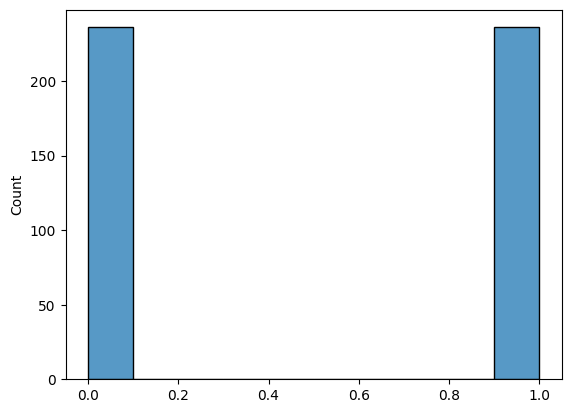

In [ ]:
sns.histplot(train_Y)